In [1]:
from disent.systems.vae import VaeSystem
from disent.visualise.util import plt_make_subplots_grid, reconstruction_to_image, reconstructions_to_images
from disent.util import to_numpy, load_model, save_model

import numpy as np
import torch
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import os

# Visualisation

# HELPER

In [2]:
def plot_sampled(system, num_samples=9):
    samples = []
    for i in range(num_samples):
        while True:
            temp = system.model.random_decoded_samples(1)
            temp = temp.cpu().detach().numpy()
            temp = np.uint8(temp * 255)
            temp = np.moveaxis(temp.reshape(-1, 3, 64, 64), 1, -1)
            if True: #temp.std() > 1: # std produces smoother results than mean
                samples.append(temp[0])
                break

    # plt_make_subplots_grid(samples, figsize=(10, 10))
    plt_make_subplots_grid(samples)
    plt.show()

def get_latent_outputs(system, num_samples=1000):
    means, logvars = [], []
    for i, batch in enumerate(DataLoader(system.dataset_train, batch_size=1, shuffle=True)):
        try:
            x, _ = batch
        except:
            x = batch
        z_mean, z_logvar = system.model.encode_gaussian(x.cuda())
        means.append(z_mean.cpu().detach().numpy()[0])
        logvars.append(z_logvar.cpu().detach().numpy()[0])
        if i >= num_samples:
            break
    means, logvars = np.array(means), np.array(logvars)
    return means, logvars #, np.exp(logvars).mean(axis=0)
    
def plot_system_mean_and_var(system, num_samples=100):
    means, logvars = get_latent_outputs(system, num_samples)
    
    means_mean, means_std = means.mean(axis=0), means.std(axis=0)
    logvars = np.exp(logvars) ** 0.5
    logvar_mean, logvar_std = logvars.mean(axis=0), logvars.std(axis=0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    
    ax1.set_title('z_mean')
    ax1.set_xlabel('idx')
    ax1.set_ylabel('value')
    ax1.errorbar(np.arange(len(means_mean)), means_mean, yerr=means_std)

    ax2.set_title('exp(z_logvar) ** 0.5')
    ax2.set_xlabel('idx')
    ax2.set_ylabel('value')
    ax2.errorbar(np.arange(len(logvar_mean)), logvar_mean, yerr=logvar_std)

def train_system(loss='ada-gvae', dataset='dsprites', model='simple-fc', z_dim=6, epochs=1, steps=None, save_path=None, load_path=None, train=True):
    system = VaeSystem(dataset_train=dataset, model=model, loss=loss, hparams=dict(num_workers=8, batch_size=64, z_dim=z_dim))
    
    if load_path:
        # system.load_from_checkpoint(checkpoint_path=PATH)
        system = load_model(system, save_path, cuda=False)

    if train:
        trainer = system.quick_train(epochs=epochs, steps=steps)

    if save_path:
        # trainer.save_checkpoint(save_path)
        save_model(system, save_path)
    
    return system, trainer
    

In [ ]:
try: del system
except: pass
try: del trainer
except: pass

PATH = 'data/trained-2000s-dsprites-simple-conv.ckpt'
system, trainer = train_system(loss='beta-vae', dataset='dsprites', steps=2000, model='simple-conv', save_path=None, load_path=None, train=True)

[DATASET: DSpritesDataset]: Loading... 

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                              | Type                 | Params
-----------------------------------------------------------------------
0  | model                             | GaussianEncoderModel | 3 M   
1  | model.gaussian_encoder            | EncoderSimpleConv64  | 1 M   
2  | model.gaussian_encoder.model      | Sequential           | 1 M   
3  | model.gaussian_encoder.model.0    | Conv2d               | 1 K   
4  | model.gaussian_encoder.model.1    | ReLU                 | 0     
5  | model.gaussian_encoder.model.2    | Conv2d               | 16 K  
6  | model.gaussian_encoder.model.3    | ReLU                 | 0     
7  | model.gaussian_encoder.model.4    | Conv2d               | 32 K  
8  | model.gaussian_encoder.model.5    | ReLU                 | 0     
9  | model.gaussian_encoder.model.6    | Conv2d               | 131 K 
10 | model.gaussian_encoder.model.7    | ReLU        

Loaded!


In [52]:
# plot_sampled(system, 100)

obs = torch.stack(system.dataset_train.sample_observations(9))
x_recon, z_mean, z_logvar, z = system.model.forward_deterministic(obs.cuda())

# imgs = reconstructions_to_images(x_recon * 100)

# plt_make_subplots_grid(imgs)
# plt.show()

0.00030243665

In [21]:
    
# plot_system_mean_and_var(system, 10000)

## MINI TESTS

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                              | Type                 | Params
-----------------------------------------------------------------------
0  | model                             | GaussianEncoderModel | 6 M   
1  | model.gaussian_encoder            | EncoderSimpleFC      | 3 M   
2  | model.gaussian_encoder.model      | Sequential           | 3 M   
3  | model.gaussian_encoder.model.0    | Flatten3D            | 0     
4  | model.gaussian_encoder.model.1    | Linear               | 3 M   
5  | model.gaussian_encoder.model.2    | ReLU                 | 0     
6  | model.gaussian_encoder.model.3    | Linear               | 32 K  
7  | model.gaussian_encoder.model.4    | ReLU                 | 0     
8  | model.gaussian_encoder.enc3mean   | Linear               | 774   
9  | model.gaussian_encoder.enc3logvar | Linear               | 774   
10 | model.decoder                     | DecoderSimpl

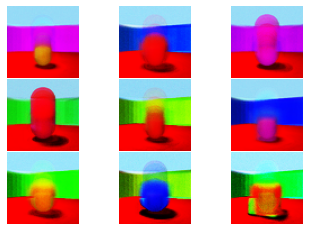

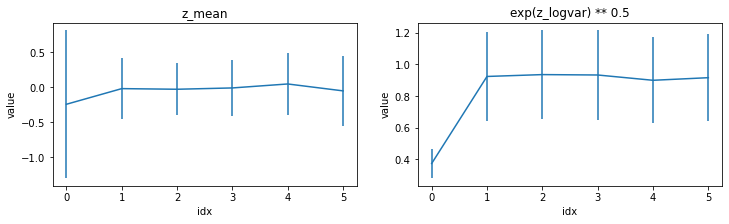

In [128]:
fc_system, fc_trainer = train_system(loss='ada-gvae', z_dim=6, epochs=1)
plot_sampled(fc_system, 9)
plot_system_mean_and_var(fc_system, 10000)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                              | Type                 | Params
-----------------------------------------------------------------------
0  | model                             | GaussianEncoderModel | 6 M   
1  | model.gaussian_encoder            | EncoderSimpleFC      | 3 M   
2  | model.gaussian_encoder.model      | Sequential           | 3 M   
3  | model.gaussian_encoder.model.0    | Flatten3D            | 0     
4  | model.gaussian_encoder.model.1    | Linear               | 3 M   
5  | model.gaussian_encoder.model.2    | ReLU                 | 0     
6  | model.gaussian_encoder.model.3    | Linear               | 32 K  
7  | model.gaussian_encoder.model.4    | ReLU                 | 0     
8  | model.gaussian_encoder.enc3mean   | Linear               | 387   
9  | model.gaussian_encoder.enc3logvar | Linear               | 387   
10 | model.decoder                     | DecoderSimpl

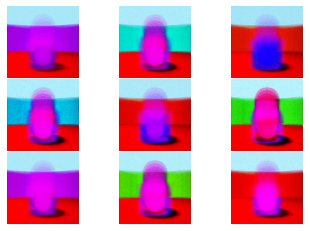

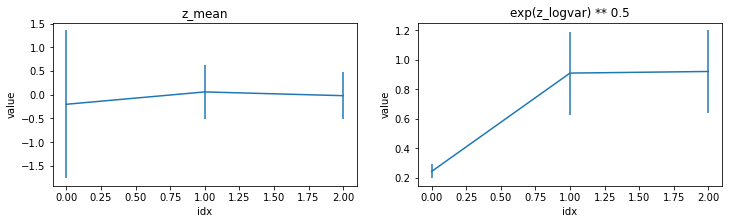

In [129]:


fc_system, fc_trainer = train_system(loss='ada-gvae', z_dim=3, epochs=1)
plot_sampled(fc_system, 9)
plot_system_mean_and_var(fc_system, 10000)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                              | Type                 | Params
-----------------------------------------------------------------------
0  | model                             | GaussianEncoderModel | 6 M   
1  | model.gaussian_encoder            | EncoderSimpleFC      | 3 M   
2  | model.gaussian_encoder.model      | Sequential           | 3 M   
3  | model.gaussian_encoder.model.0    | Flatten3D            | 0     
4  | model.gaussian_encoder.model.1    | Linear               | 3 M   
5  | model.gaussian_encoder.model.2    | ReLU                 | 0     
6  | model.gaussian_encoder.model.3    | Linear               | 32 K  
7  | model.gaussian_encoder.model.4    | ReLU                 | 0     
8  | model.gaussian_encoder.enc3mean   | Linear               | 1 K   
9  | model.gaussian_encoder.enc3logvar | Linear               | 1 K   
10 | model.decoder                     | DecoderSimpl

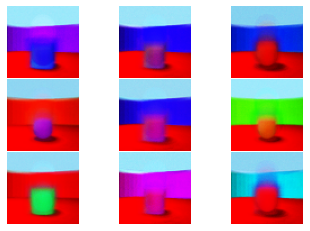

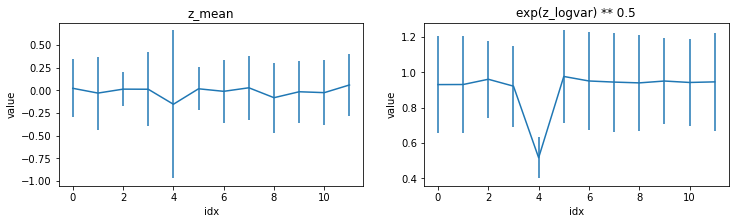

In [130]:
fc_system, fc_trainer = train_system(loss='ada-gvae', z_dim=12, epochs=1)
plot_sampled(fc_system, 9)
plot_system_mean_and_var(fc_system, 10000)

In [ ]:
z_mean, z_logvar = N()



INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                              | Type                 | Params
-----------------------------------------------------------------------
0  | model                             | GaussianEncoderModel | 6 M   
1  | model.gaussian_encoder            | EncoderSimpleFC      | 3 M   
2  | model.gaussian_encoder.model      | Sequential           | 3 M   
3  | model.gaussian_encoder.model.0    | Flatten3D            | 0     
4  | model.gaussian_encoder.model.1    | Linear               | 3 M   
5  | model.gaussian_encoder.model.2    | ReLU                 | 0     
6  | model.gaussian_encoder.model.3    | Linear               | 32 K  
7  | model.gaussian_encoder.model.4    | ReLU                 | 0     
8  | model.gaussian_encoder.enc3mean   | Linear               | 774   
9  | model.gaussian_encoder.enc3logvar | Linear               | 774   
10 | model.decoder                     | DecoderSimpl

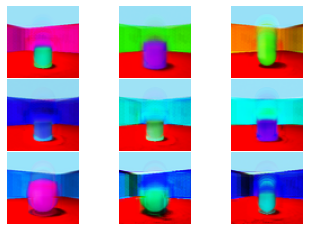

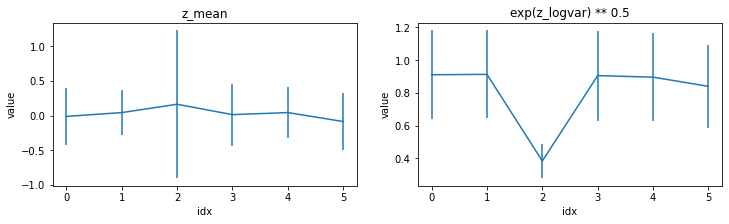

In [138]:
fc_system, fc_trainer = train_system(loss='beta-vae', z_dim=6, epochs=5)
plot_sampled(fc_system, 9)
plot_system_mean_and_var(fc_system, 10000)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                              | Type                 | Params
-----------------------------------------------------------------------
0  | model                             | GaussianEncoderModel | 6 M   
1  | model.gaussian_encoder            | EncoderSimpleFC      | 3 M   
2  | model.gaussian_encoder.model      | Sequential           | 3 M   
3  | model.gaussian_encoder.model.0    | Flatten3D            | 0     
4  | model.gaussian_encoder.model.1    | Linear               | 3 M   
5  | model.gaussian_encoder.model.2    | ReLU                 | 0     
6  | model.gaussian_encoder.model.3    | Linear               | 32 K  
7  | model.gaussian_encoder.model.4    | ReLU                 | 0     
8  | model.gaussian_encoder.enc3mean   | Linear               | 387   
9  | model.gaussian_encoder.enc3logvar | Linear               | 387   
10 | model.decoder                     | DecoderSimpl

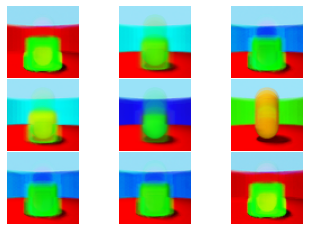

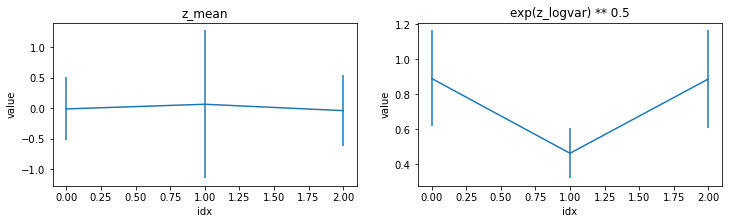

In [136]:
fc_system, fc_trainer = train_system(loss='beta-vae', z_dim=3, epochs=5)
plot_sampled(fc_system, 9)
plot_system_mean_and_var(fc_system, 10000)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                              | Type                 | Params
-----------------------------------------------------------------------
0  | model                             | GaussianEncoderModel | 6 M   
1  | model.gaussian_encoder            | EncoderSimpleFC      | 3 M   
2  | model.gaussian_encoder.model      | Sequential           | 3 M   
3  | model.gaussian_encoder.model.0    | Flatten3D            | 0     
4  | model.gaussian_encoder.model.1    | Linear               | 3 M   
5  | model.gaussian_encoder.model.2    | ReLU                 | 0     
6  | model.gaussian_encoder.model.3    | Linear               | 32 K  
7  | model.gaussian_encoder.model.4    | ReLU                 | 0     
8  | model.gaussian_encoder.enc3mean   | Linear               | 1 K   
9  | model.gaussian_encoder.enc3logvar | Linear               | 1 K   
10 | model.decoder                     | DecoderSimpl

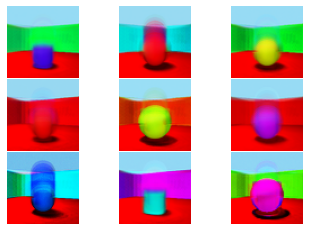

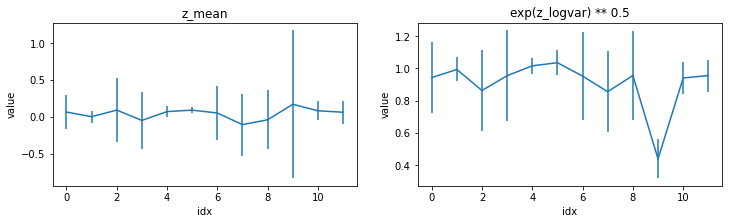

In [137]:
fc_system, fc_trainer = train_system(loss='beta-vae', z_dim=12, epochs=5)
plot_sampled(fc_system, 9)
plot_system_mean_and_var(fc_system, 10000)

In [ ]:
[6, 6, 6, 24 , 3, 2]